In deze notebook wordt een Lorentzmodel gefit op data van een meting van fotonen. \
Hiervoor wordt eerst de $\chi^2$ waarde bepaald van het model in functie van de parameters en wordt dit geminimaliseerd om de best fittende parameters te bepalen. 
Vervolgens worden de fouten op de parameters een voor een bepaald. Hierbij worden alle parameters buiten diegene waarop de fout bepaald wordt vast genomen als de minimale waarde. Dan worden de snijpunten van $\chi^2$ in functie van de overblijvende parameter met de $1\sigma$ hypercontour van de $\chi^2$ functie voor het model bepaald. Dit wordt herhaald voor elke parameter, waardoor voor elke parameter ook een $68 \%$ betrouwbaarheidsinterval bepaald kan worden.

Eerst wordt de code gegeven om al deze waardes te bepalen, waarbij ook tussenresultaten getoond worden. Dan worden alle resultaten op het einde van het notebook nog eens samengevat en duidelijk gepresenteerd. <br>Ten slotte worden ook de gereduceerde $\chi^2$ waarde $\chi^2_{red}$ en de p-waarde besproken om de kwaliteit van de fit en het model te bepalen op $5\%$ significantieniveau.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fsolve
from scipy.stats import chi2
parameters = ["x_0", "gamma", "A", "y_0"]

We zullen er voor deze notebook van uit gaan dat de intensiteit in de eenheid $\frac{W}{(mm)^2}$ gegeven wordt. Er is immers geen eenheid gegeven en dit zal verderop gemakkelijker rekenen.

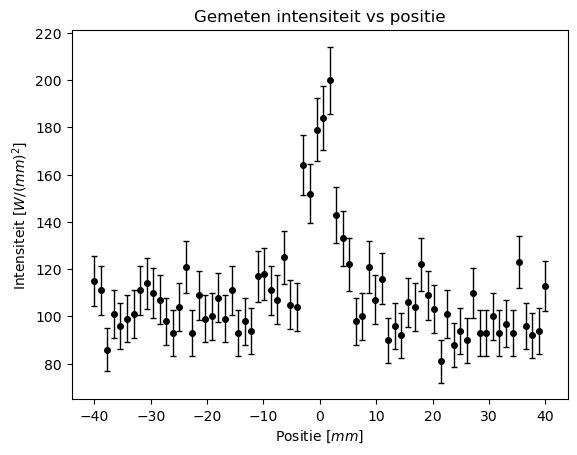

In [2]:
dataset = 6 #Geeft aan welke dataset gefit moet worden
data = np.loadtxt("data_fitopgave/%s.txt" %dataset, delimiter  =" ").T #Data inladen en in onderstaande regels uitpakken
positie, intensiteit = data[0], data[1]
fouten = np.sqrt(intensiteit) #Aangezien de intensiteit een telling is van fotonen is dit een Poisson verdeling dus is \sigma = sqrt(I)
fig, ax = plt.subplots(1,1) #De data plotten
ax.errorbar(positie, intensiteit, yerr = fouten, fmt = 'ko', ecolor = 'k', capsize = 2.5, markersize = 4, elinewidth = 1)
ax.set_xlabel("Positie $[mm]$")
ax.set_ylabel("Intensiteit $[W/(mm)^2]$")
ax.set_title("Gemeten intensiteit vs positie")
plt.show()

Om initiële waardes te bepalen waarvan vertrokken wordt om $\chi^2 (x_0, \gamma, A, y_0)  := \chi^2(\vec{\theta})$ te minimaliseren worden eerst benaderingen bepaald voor deze parameters a.d.h.v. de data.

Bemerk hiervoor dat de minimale y-waarde ongeveer de ofset $y_0$ zal moeten zijn en de x-waarde waar y maximaal wordt ongeveer de verschuiving $x_0$ moet zijn. 

Hierna kunnen via deze maximale y-waarde en die bij de eerstvolgende x-waarde zowel $A$ als $\gamma$ bepaald worden.
Immers is $\frac{A}{\pi} \frac{\gamma}{\gamma^2} = y_{max} - y_0$ en kunnen we voor een $x$ rond $x_0$ de y-waarde $y_1$ noemen zodat $\frac{A}{\pi} \frac{\gamma}{(\Delta x)^2 + \gamma^2} = a - y_0$ met $\Delta x = x-x_0$. Deze twee vergelijkingen geven nu als oplossing:
$$ \gamma = |\Delta x|\sqrt{\frac{y_1 - y_0}{y_{max} - y_1}}$$
$$ A = \pi |\Delta x|(y_{max} - y_0)\sqrt{\frac{y_1-y_0}{y_{max} - y_1}} = \pi \gamma (y_{max} - y_0) $$

In [3]:
def model(x, param):
    """Geeft de waarde voorspeld door het model in functie van x.
        Bemerk dat deze functie steeds opnieuw ingesteld moet worden als een ander model gefit wordt!
    
    Args:
        x: De waarde waarin het model geevalueerd moet worden
        param: Een vector van alle gebruikte parameters
    
    Return: De modelwaarde met parameters param in x.
    """
    x_0, gamma, A, y_0 = param
    return (A/np.pi) * (gamma/((x-x_0)**2 + gamma**2)) + y_0
    
    
def initial_vals_chi2(x_val, y_val):
    """Geeft op basis van de datapunten een vector van initiële waardes voor alle parameters.
        Bemerk dat deze functie aangepast moet worden als een ander model gebruikt wordt.
    
    Args:
        X_val: De x-waardes die in het model ingevuld worden
        y_val: De uitvoer waardes van het model
    
    Return:
        gok: Een vector initiële waardes voor de minimalisatie van chi2. Dit is een np.array met initiële waardes voor
                de parameters in dezelfde volgorde die gehanteerd wordt in de functie "model(x, param)"
    """
    y_0_gok = np.min(y_val)
    x_0_gok = x_val[np.argmax(y_val)]
    x_close = max(x_val[np.argmax(y_val) + 1], x_val[np.argmax(y_val)-1])
    y_close = y_val[np.where(x_val == x_close)][0] - y_0_gok #Dit rekent verder gemakkelijker
    y_max = np.max(y_val) - y_0_gok #Idem
    gamma_gok = abs(x_0_gok - x_close)*np.sqrt(y_close/(y_max - y_close))
    A_gok = gamma_gok * np.pi * y_max
    return np.array([x_0_gok, gamma_gok, A_gok, y_0_gok])


def chi2_bereken(param, x_val, y_val, y_err):
    """Geeft de chi^2 waarde in functie van de parameters
    
    Args: 
        param: Waardes voor de parameters van het model
        x_val: Een vector van invoerwaardes voor het model
        y_val: Een vector met meetwaardes die gefit worden
        y_err: Een vector met de fouten op y
        
    Return:
        chi_2_val: De chi^2 waarde van het model gegeven de waardes voor de parameters uit param.
        
    """
    chi_2_val = np.sum((y_val - model(x_val, param))**2 / y_err**2) #Dit is de formule voor de chi^2 waarde van een model
    return chi_2_val


def minimize_chi2(x_val, y_val, y_err):
    """Minimaliseert de chi^2 waarde voor een gegeven model en een aantal datapunten
    
    Args:
        x_val: Een vector van invoerwaardes voor het model
        y_val: Een vector met meetwaardes die gefit moeten worden
        y_err: Een vector met de fouten op y
                    
    Return:
        oplossing: Een array dat de minimale waardes voor de parameters geeft
    """
    #lambda calculus wordt gebruikt om chi2 eenvoudig te definiëren als functie voor gebruik van scipy.optimize.minimize
    chi2_func = lambda *args: chi2_bereken(*args) 
    gok = initial_vals_chi2(x_val, y_val)
    #Zoals de naam doet verwachten zal de minimize functie de gegeven functie minimaliseren in functie van de argumenten die
    #niet meegegeven worden in args
    oplossing = minimize(chi2_func, gok, args = (x_val, y_val, y_err)) 
    return oplossing

Nu kunnen de optimale parameters bepaald worden voor het model

In [4]:
minimum = minimize_chi2(positie, intensiteit, fouten)
#De functie minimize geeft een dictionary terug, dus halen worden de optimale parameters en minimale chi^2 als volgt gevonden.
min_param = minimum["x"]
chi_min = minimum["fun"]
display(min_param)
display(chi_min)

array([5.17611303e-01, 2.51312304e+00, 7.62521763e+02, 9.92660045e+01])

69.60237489314733

Met de optimale parameters wordt dus volgende fit bekomen

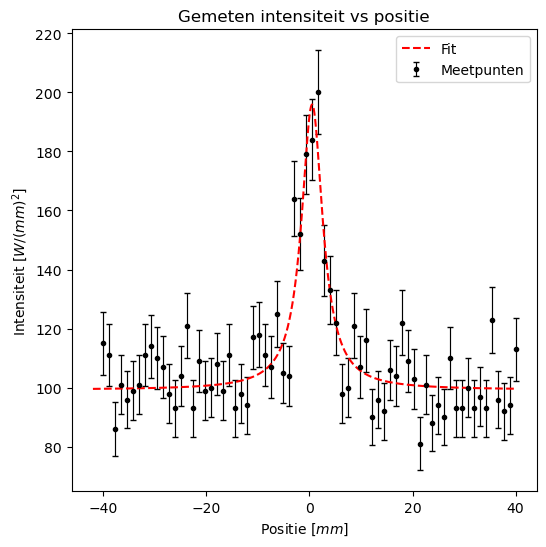

In [5]:
fig, ax = plt.subplots(1,1, figsize = (6,6))
X = np.linspace(positie[0] - 2, positie[len(positie) - 1], 10000) #Dit is input voor het model
ax.errorbar(positie, intensiteit, yerr = fouten, fmt = 'ko', ecolor = 'k', capsize = 2, 
            markersize = 3, elinewidth = 0.85, label = "Meetpunten")
ax.plot(X, model(X, min_param), 'r--', label = "Fit")
ax.legend()
ax.set_xlabel("Positie $[mm]$")
ax.set_ylabel("Intensiteit $[W/(mm)^2]$")
ax.set_title("Gemeten intensiteit vs positie")
plt.show()

Vervolgens worden de fouten op de verschillende parameters bepaald. \
Hiervoor wordt eerst een hulpfunctie gedefinieerd die toelaat om $\chi^2(\vec{\theta})$ te definiëren als functie van 1 parameter als de andere parameters vast genomen worden. Dan worden de snijpunten van $\chi^2(\vec{\theta})$ met de $1\sigma$ hypercontour van de $\chi^2_{\mu}$, met $\mu$ het aantal parameters, numerisch bepaald met behulp van de scipy.optimize.fsolve functie. Deze bepaalt de nulpunten van een functie. De gevonden snijpunten geven dan het 68% betrouwbaarheidsinterval (BI) voor de parameters.

In [6]:
def chi2_in_1_var(var, ind_var, x_val, y_val, y_err, param_values, chi_min):
    """ Herdefiniëert chi2(theta) slechts van de parameter op de ind_var plaats af te hangen. Hierbij worden de andere parameters
        vast genomen. Bovendien wordt de functie ook genormaliseerd zodat het nul is wanneer 
        het de 1\sigma hypercontour van de chi^2_mu verdeling snijdt
        
        Args:
            var: Een vector van waardes voor de parameter in functie waarvan chi^2 gedefineerd wordt.
            ind_var: De index van de parameter in de parameter vector in functie waarvan chi^2 gedefinieerd moet worden.
            x_val,y_val,y_err: De gemeten data en de fout er op
            param_values: Een vector die de waardes voor de parameters die niet dienen als argument van de geherdefinieerde chi^2 functie geeft.
            chi_min: De minimale chi^2 waarde van het model gevonden in minimize_chi2()
        
        Return:
            outp: Een vector die de genormaliseerde waardes van chi^2(theta) met als parameters var en param_values geeft.
    
    """
    outp = np.array([])
    aant_param = len(param_values)
    for val in var: #Laat deze functie een vector gebruiken voor var i.p.v. slechts 1 waarde.
        #Deze regel dient om de referentie semantiek van lijsten te omzeilen. Zonder dit wordt de vector param_values globaal aangepast
        kopie = param_values.copy()
         #De waarde van var wordt op de juiste index ingevuld in de parameter vector.
        np.put(kopie, ind_var, val)
        outp = np.append(outp, chi2_bereken(kopie, x_val, y_val, y_err) - chi2.ppf(0.68, df=aant_param) - chi_min)
    return outp

def find_sigma_values(x_val, y_val, y_err, param_values, te_checken_param_ind, chi_min):
    """ Geeft de boven en ondergrens van het 68% BI voor de aangegeven parameter.
    
        Args:
            x_val, y_val, y_err: De data en de fouten er op.
            param_values: De parameter waardes die de beste fit geven.
            te_checken_param_ind: De index van de parameter waarvoor het BI bepaald wordt.
            chi_min: De chi^2 waarde van het model bij de best fittende parameters.    
        
        Return:
            [oplossing_min[0], oplossing_max[0]]: Het 68% BI voor de parameter met index te_checken_param_ind in de parameter vector.
            
    """
    functie = lambda *args: chi2_in_1_var(*args)
    #De snijpunten met de 1\sigma hypercontour van de chi^2_mu verdeling zullen rond de best fittende waardes liggen
    gok = param_values[te_checken_param_ind]
    #scipy.optimize.fsolve vindt de nulpunten van de gegeven functie, chi2_in_1_var is gedefinieerd zodat de gezochte boven
    #en ondergrenzen van het BI precies de nulpunten zijn.
    #Om de bovengrens te vinden wordt een initiële waarde boven de best fittende waarde genomen, omgekeerd voor de ondergrens.
    oplossing_max = fsolve(functie, args = (te_checken_param_ind, x_val, y_val, y_err, param_values, chi_min), x0 = gok + abs(gok)/2)
    oplossing_min = fsolve(functie, args = (te_checken_param_ind, x_val, y_val, y_err, param_values, chi_min), x0 = gok - abs(gok)/2)
    return [oplossing_min[0], oplossing_max[0]]
    
def uncertainty_intervals(min_values, x_val, y_val, y_err,  chi_min):
    """Geeft de 68% BI voor alle parameters van het model
    
        Args:
            min_values: De best fittende waardes voor de parameters.
            x_val, y_val, y_err: De data en de fouten er op.
            chi_min: De chi^2 waarde van het model bij de best fittende parameters.
            
        Return:
            intervallen: De 68% BI voor alle parameters.
    
    """
    aant_param = len(min_values)
    intervallen = []
    for i in range(0, aant_param):
        intervallen.append(find_sigma_values(x_val, y_val, y_err, min_values, i, chi_min))
    return intervallen

Nu kunnen de gezochte 68% betrouwbaarheidsintervallen bepaald worden:

In [7]:
betr_intervallen = uncertainty_intervals(min_param, positie, intensiteit, fouten, chi_min)
for i in range(0, len(betr_intervallen)):
    outp = parameters[i]
    outp+= " heeft als waarde: %.5g met 68%% betrouwbaarheidsinterval: [%.5g, %.5g] "%(min_param[i], betr_intervallen[i][0], betr_intervallen[i][1])
    display(outp)

'x_0 heeft als waarde: 0.51761 met 68% betrouwbaarheidsinterval: [-0.067043, 1.0771] '

'gamma heeft als waarde: 2.5131 met 68% betrouwbaarheidsinterval: [2.0438, 3.1692] '

'A heeft als waarde: 762.52 met 68% betrouwbaarheidsinterval: [642.38, 882.66] '

'y_0 heeft als waarde: 99.266 met 68% betrouwbaarheidsinterval: [96.599, 101.93] '

Nu worden er plots gegeven waarop de snijpunten van $\chi^2(\vec{\theta})$ met de $1\sigma$ hypercontour van de $\chi^2_{\mu}$ verdeling weergegeven worden.

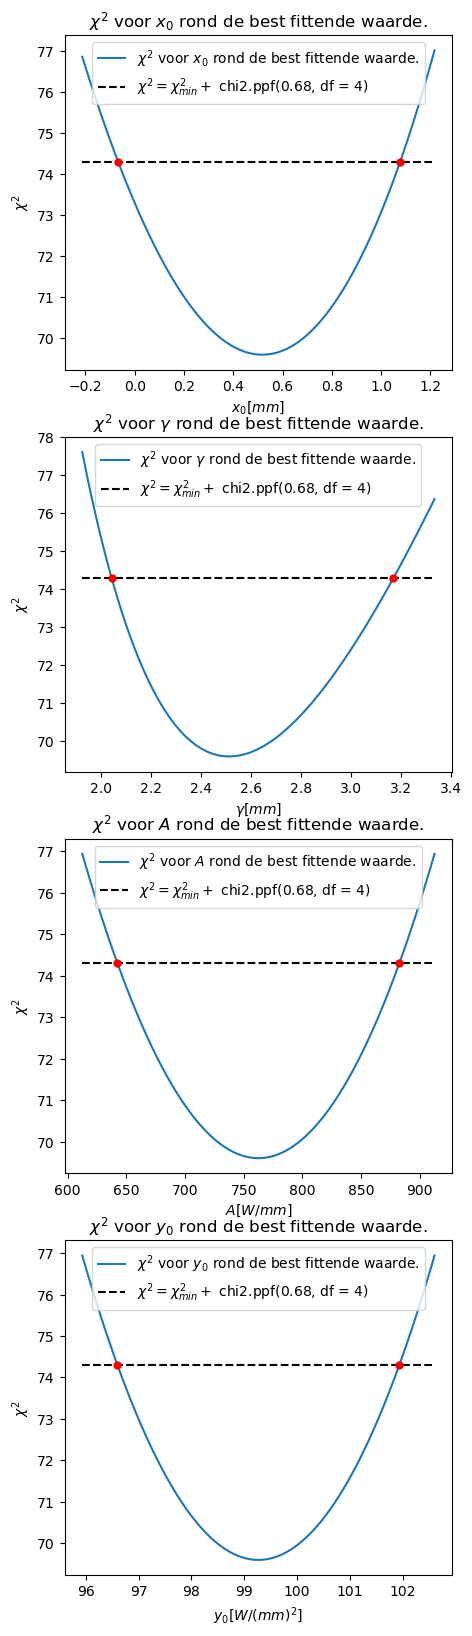

In [8]:
def chi2_plots(betr_intervallen, min_param, chi_min, x_val, y_val, y_err):
    aant_param = len(betr_intervallen)
    #chi_exp is de waarde van chi^2 op de 1 \sigma hypercontour.
    chi_exp = np.full(1000,chi_min + chi2.ppf(0.68, df=aant_param))
    titels = ["$\chi^2$ voor $x_0$ rond de best fittende waarde.",
          "$\chi^2$ voor $\gamma$ rond de best fittende waarde.",
          "$\chi^2$ voor $A$ rond de best fittende waarde.",
          "$\chi^2$ voor $y_0$ rond de best fittende waarde."]
    xlabels = ["$x_0 [mm]$","$\gamma [mm]$", "$A [W/mm]$", "$y_0 [W/(mm)^2]$"]
    chi_vali_labels = ["$\chi^2$ voor $x_0$ rond de best fittende waarde.",
                   "$\chi^2$ voor $\gamma$ rond de best fittende waarde.",
                   "$\chi^2$ voor $A$ rond de best fittende waarde.",
                   "$\chi^2$ voor $y_0$ rond de best fittende waarde."]
    fig, ax = plt.subplots(aant_param, 1, figsize = (5, 5*aant_param))
    for i in range(0, aant_param):
        #top en bot zijn respectievelijk de 1 \sigma afwijkingen naar boven en onder.
        top = betr_intervallen[i][1] - min_param[i]
        bot = min_param[i] - betr_intervallen[i][0]
        i_range = np.linspace(min_param[i] - bot*1.25, min_param[i] + top*1.25, 1000)
        chi_vali = chi2_in_1_var(i_range, i, x_val, y_val, y_err, min_param, chi_min) + np.full(1000, chi2.ppf(0.68, df=aant_param) + chi_min)
        ax[i].plot(i_range, chi_vali, label = chi_vali_labels[i])
        ax[i].plot(i_range, chi_exp, 'k--', label = "$\chi^2 = \chi^2_{min} +$ chi2.ppf(0.68, df = %d)"%aant_param)
        ax[i].plot(betr_intervallen[i], np.full(2,chi_min + chi2.ppf(0.68, df=aant_param)),'ro', markersize = 5)
        ax[i].set_title(titels[i])
        ax[i].set_xlabel(xlabels[i])
        ax[i].set_ylabel("$\chi^2$")
        ax[i].legend()
    plt.show()

chi2_plots(betr_intervallen, min_param, chi_min, positie, intensiteit, fouten)

Nu kunnen nog de p-waarde voor de hypothese test dat het model zinvol is en ook de gereduceerde $\chi^2$ waarde bepaald worden. 

In [9]:
nu = len(positie) - len(min_param)
p_waarde = chi2.sf(chi_min, df=nu)
chi_red = chi_min/nu
print("De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: %.5g"%p_waarde)
print("De gereduceerde chi^2 waarde is: %.5g"%chi_red)

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0.35725
De gereduceerde chi^2 waarde is: 1.0546


Ten slotte worden alle resultaten hier voor het gemak eenvoudig samengezet. Eerst worden de ruwe data en de ruwe data met de optimale fit gegeven. Hierna worden de optimale fitparameters weergegeven, samen met de $\chi^2(\vec{\theta})$ plots voor elke parameter. Dan worden de p-waarde en gereduceerde $\chi^2$ waarde ook nog weergegeven. Hierna worden de fitparameters nog eens met hun onzekerheid naar boven en naar onder weergegeven in een tekst blok, samen met een bespreking van de kwaliteit van de fit.

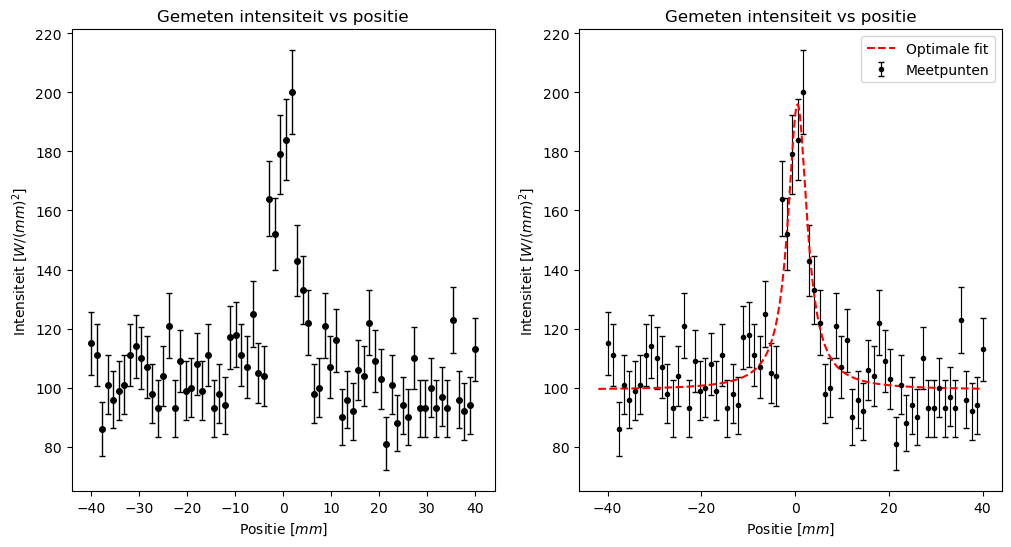

x_0 heeft als waarde: 0.51761 met 68% betrouwbaarheidsinterval: [-0.067043, 1.0771] 
gamma heeft als waarde: 2.5131 met 68% betrouwbaarheidsinterval: [2.0438, 3.1692] 
A heeft als waarde: 762.52 met 68% betrouwbaarheidsinterval: [642.38, 882.66] 
y_0 heeft als waarde: 99.266 met 68% betrouwbaarheidsinterval: [96.599, 101.93] 


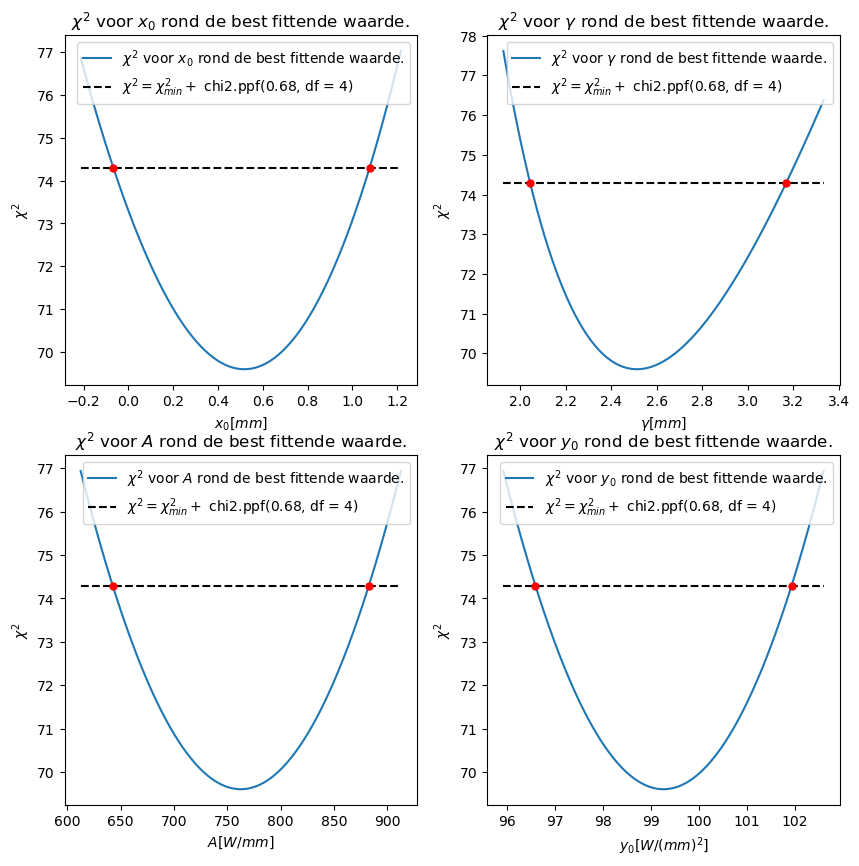

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0.35725
De gereduceerde chi^2 waarde is: 1.0546


In [10]:
def opt_fit_and_bare(x_val, y_val, y_err, min_param):
    fig, ax = plt.subplots(1,2, figsize = (12,6))
    #De data alleen plotten
    ax[0].errorbar(positie, intensiteit, yerr = fouten, fmt = 'ko', ecolor = 'k', capsize = 2.5, markersize = 4, elinewidth = 1)
    ax[0].set_xlabel("Positie $[mm]$")
    ax[0].set_ylabel("Intensiteit $[W/(mm)^2]$")
    ax[0].set_title("Gemeten intensiteit vs positie")
    
    #De data met de optimale fit plotten
    X = np.linspace(positie[0] - 2, positie[len(positie) - 1], 10000) #Dit is input voor het model
    ax[1].errorbar(positie, intensiteit, yerr = fouten, fmt = 'ko', ecolor = 'k', capsize = 2, 
            markersize = 3, elinewidth = 0.85, label = "Meetpunten")
    ax[1].plot(X, model(X, min_param), 'r--', label = "Optimale fit")
    ax[1].legend()
    ax[1].set_xlabel("Positie $[mm]$")
    ax[1].set_ylabel("Intensiteit $[W/(mm)^2]$")
    ax[1].set_title("Gemeten intensiteit vs positie")
    plt.show()
    
def pretty_print_param(min_param, betr_intervallen, chi_min, x_val, y_val, y_err):
    #De waardes voor de parameters printen
    for i in range(0, len(betr_intervallen)):
        outp = parameters[i] + " heeft als waarde: %.5g met 68%% betrouwbaarheidsinterval: [%.5g, %.5g] "%(min_param[i], betr_intervallen[i][0], betr_intervallen[i][1])
        print(outp)
        
    #De chi^2 plots maken
    aant_param = len(betr_intervallen)
    chi_exp = np.full(1000,chi_min + chi2.ppf(0.68, df=aant_param))
    titels = ["$\chi^2$ voor $x_0$ rond de best fittende waarde.",
          "$\chi^2$ voor $\gamma$ rond de best fittende waarde.",
          "$\chi^2$ voor $A$ rond de best fittende waarde.",
          "$\chi^2$ voor $y_0$ rond de best fittende waarde."]
    xlabels = ["$x_0 [mm]$","$\gamma [mm]$", "$A [W/mm]$", "$y_0 [W/(mm)^2]$"]
    chi_vali_labels = ["$\chi^2$ voor $x_0$ rond de best fittende waarde.",
                   "$\chi^2$ voor $\gamma$ rond de best fittende waarde.",
                   "$\chi^2$ voor $A$ rond de best fittende waarde.",
                   "$\chi^2$ voor $y_0$ rond de best fittende waarde."]
    fig, ax = plt.subplots(2, 2, figsize = (10, 10))
    for i in range(0, 2):
        for j in range(0,2):
            #top en bot zijn respectievelijk de 1 \sigma afwijkingen naar boven en onder.
            top = betr_intervallen[2*i + j][1] - min_param[2*i + j]
            bot = min_param[2*i + j] - betr_intervallen[2*i + j][0]
            i_range = np.linspace(min_param[2*i + j] - bot*1.25, min_param[2*i + j] + top*1.25, 1000)
            chi_vali = chi2_in_1_var(i_range, 2*i + j, x_val, y_val, y_err, min_param, chi_min) + np.full(1000, chi2.ppf(0.68, df=aant_param) + chi_min)
            ax[i][j].plot(i_range, chi_vali, label = chi_vali_labels[2*i+j])
            ax[i][j].plot(i_range, chi_exp, 'k--', label = "$\chi^2 = \chi^2_{min} +$ chi2.ppf(0.68, df = %d)"%aant_param)
            ax[i][j].plot(betr_intervallen[2*i + j], np.full(2,chi_min + chi2.ppf(0.68, df=aant_param)),'ro', markersize = 5)
            ax[i][j].set_title(titels[2*i + j])
            ax[i][j].set_xlabel(xlabels[2*i + j])
            ax[i][j].set_ylabel("$\chi^2$")
            ax[i][j].legend()
    plt.show()
    
def print_p_val_en_chi2_red(chi_min, x_val, min_param):
    nu = len(x_val) - len(min_param)
    p_waarde = chi2.sf(chi_min, df=nu)
    chi_red = chi_min/nu
    print("De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: %.5g"%p_waarde)
    print("De gereduceerde chi^2 waarde is: %.5g"%chi_red)

def pretty_print_results(x_val, y_val, y_err, chi_min, min_param, betr_intervallen):
    opt_fit_and_bare(x_val, y_val, y_err, min_param)
    pretty_print_param(min_param, betr_intervallen, chi_min, x_val, y_val, y_err)
    print_p_val_en_chi2_red(chi_min, x_val, min_param)


pretty_print_results(positie, intensiteit, fouten, chi_min, min_param, betr_intervallen)

De code geeft dus volgende waardes voor de beste fitparameters:
$$ x_0 = (0.52_{-0.58}^{+0.56})mm$$
$$ \gamma = (2.51_{-0.47}^{+0.66})mm$$
$$ A = (7.6 \pm 1.2)* 10^2 \frac{W}{mm}$$
$$ y_0 = (99.3 \pm 2.7) \frac{W}{(mm)^2}$$

Nu kan een hypothese test uitgevoerd worden op de hypothese $H_0$: Het Lorentz model is een goed model voor deze data. op 5% significantieniveau.\
Hier is de teststatistiek de minimale $\chi^2$ waarde die in deze notebook gevonden werd. Deze heeft, zoals gevonden, een p-waarde van 0.357. Er kan dus op significantieniveau 5% niet verworpen worden dat het Lorentz model een goed model is voor deze data.\
Nu zal er ook gecontroleerd worden of er geconcludeerd mag worden dat $\chi^2_{red} \approx 1$. Bemerk hiertoe dat de $\chi^2_{66}/66$ (de verdeling van $\chi^2_{red}$) verdeling een som is van i.i.d. stochastische variabelen en dus bij benadering normaal verdeeld zal zijn voor voldoende vrijheidsgraden. Aangezien voor de $\chi^2_n$ verdeling het gemiddelde $n$ is en de variantie $2n$, is het dus voldoende dat de gevonden gereduceerde $\chi^2_{red}$ waarde minder dan $\sqrt{(2/(N-p)} = 1\sigma$ van 1 ligt, waarbij $N$ het aantal datapunten en $p$ het aantal parameters.. Aangezien $N = 70, p = 4$ zal $1 \sigma = 0.174$, zodat de gevonden gereduceerde $\chi^2_{red}$ waarde van $1.055$ inderdaad voldoende dichtbij 1 ligt om te concluderen dat er geen onder- of overfitting is. <br>
De finale conclusie die dus getrokken kan worden is dat het Lorentz model een goed model is voor deze data en geen over- of underfitting geeft.